# Import Libraries

In [1]:
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataset import dataset_MOT_segmented
from models import vqvae
from options import option_vq
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Load Data

In [3]:
# Create the data loader (adjust window_size, batch_size as needed)
loader = dataset_MOT_segmented.addb_data_loader(data_dir='/home/kingn450/Datasets/addb_dataset_publication', mode='all')


100%|██████████| 56/56 [00:17<00:00,  3.21it/s]

Total number of motions: 789


# Setup Model

In [3]:
# Set up args with the same parameters as in run.log
class Args:
    dataname = "mcs"
    nb_code = 512
    code_dim = 512
    output_emb_width = 512
    down_t = 2
    stride_t = 2
    width = 512
    depth = 3
    dilation_growth_rate = 3
    vq_act = "relu"
    vq_norm = None
    quantizer = "ema_reset"
    mu = 0.99


args = Args()

# Instantiate the model
model = vqvae.HumanVQVAE(
    args,
    nb_code=args.nb_code,
    code_dim=args.code_dim,
    output_emb_width=args.output_emb_width,
    down_t=args.down_t,
    stride_t=args.stride_t,
    width=args.width,
    depth=args.depth,
    dilation_growth_rate=args.dilation_growth_rate,
    activation=args.vq_act,
    norm=args.vq_norm
)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ckpt = torch.load("/home/kingn450/git_repositories/BIGE/checkpoints/VQVAE9_Bs32/10000.pth", map_location=device)

# Remove 'module.' prefix if present
state_dict = ckpt['net']
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace('module.', '') if k.startswith('module.') else k
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict, strict=True)
model.eval()

# Access the encoder
encoder = model.vqvae.encoder

# Create Latent Embeddings

In [4]:
from collections import defaultdict
import os

def extract_subject_from_name(name):
    b3d_path = name.split("::")[0]
    parts = b3d_path.split(os.sep)
    if len(parts) >= 2:
        folder = parts[-2]
        # If '_split' in folder, take everything before '_split'
        if '_split' in folder:
            return folder.split('_split')[0]
        else:
            return folder
    else:
        return "unknown_subject"

subject_latents = defaultdict(list)

with torch.no_grad():
    for batch in loader:
        motions, lengths, names, subject_names = batch
        motions = motions.to(device, dtype=torch.float32)
        latents = model.vqvae.encoder(model.vqvae.preprocess(motions))
        for latent, name, subject_name in zip(latents, names, subject_names):
            subject_latents[subject_name].append(latent.cpu())

# Profile Encoder and Decoder

## Self-Attentive Pooling

In [5]:
class ProfileEncoder(nn.Module):
    def __init__(self, latent_dim, profile_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=4, batch_first=True)
        self.net = nn.Sequential(
            nn.Linear(latent_dim, profile_dim)
        )
    def forward(self, latents):
        if latents.dim() == 2:
            x = latents.unsqueeze(0)  
        else:
            x = latents  
        attn_out, _ = self.attn(x, x, x) 
        pooled = attn_out.mean(dim=1)
        return self.net(pooled)

class ProfileDecoder(nn.Module):
    def __init__(self, profile_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(profile_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),   
            nn.Linear(512, latent_dim)
        )
    def forward(self, profile):
        return self.net(profile)

# Training Loop

In [6]:
# Pick two subjects with at least 2 motions each
subjects = [s for s in subject_latents if len(subject_latents[s]) >= 2]
if len(subjects) < 2:
    raise ValueError("Need at least two subjects with >=2 motions each.")

subject_pos = subjects[0]
subject_neg = subjects[1]
latents_pos = subject_latents[subject_pos]
latents_neg = subject_latents[subject_neg]

latent_dim = latents_pos[0].shape[-1]
profile_dim = 128

encoder = ProfileEncoder(latent_dim, profile_dim).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3, weight_decay=1e-4)
triplet_loss_fn = torch.nn.TripletMarginLoss(margin=0.2, p=2)

num_epochs = 1000
for epoch in range(num_epochs):
    idx = np.random.choice(len(latents_pos), 2, replace=False)
    anchor = latents_pos[idx[0]].unsqueeze(0).to(device)
    positive = latents_pos[idx[1]].unsqueeze(0).to(device)
    negative = latents_neg[np.random.choice(len(latents_neg))].unsqueeze(0).to(device)

    anchor_emb = F.normalize(encoder(anchor), dim=0)
    positive_emb = F.normalize(encoder(positive), dim=0)
    negative_emb = F.normalize(encoder(negative), dim=0)

    loss = triplet_loss_fn(anchor_emb, positive_emb, negative_emb)
    loss.backward()
    ap_dist = torch.norm(anchor_emb - positive_emb).item()
    an_dist = torch.norm(anchor_emb - negative_emb).item()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch {epoch}: Loss {loss.item():.4f}")

encoder.eval()

Epoch 0: Loss 0.2000
Epoch 1: Loss 0.0000
Epoch 2: Loss 0.0000
Epoch 3: Loss 0.0000
Epoch 4: Loss 0.2000
Epoch 5: Loss 0.0000
Epoch 6: Loss 0.0000
Epoch 7: Loss 0.0000
Epoch 8: Loss 0.0000
Epoch 9: Loss 3.0284
Epoch 10: Loss 0.8357
Epoch 11: Loss 0.0000
Epoch 12: Loss 0.0000
Epoch 13: Loss 0.0000
Epoch 14: Loss 0.0000
Epoch 15: Loss 0.7359
Epoch 16: Loss 1.0284
Epoch 17: Loss 0.0000
Epoch 18: Loss 2.2000
Epoch 19: Loss 2.2000
Epoch 20: Loss 0.2000
Epoch 21: Loss 0.2000
Epoch 22: Loss 0.2000
Epoch 23: Loss 0.0000
Epoch 24: Loss 0.2000
Epoch 25: Loss 0.2000
Epoch 26: Loss 0.2000
Epoch 27: Loss 0.0000
Epoch 28: Loss 0.2000
Epoch 29: Loss 0.2000
Epoch 30: Loss 0.2000
Epoch 31: Loss 0.2000
Epoch 32: Loss 0.2000
Epoch 33: Loss 0.0000
Epoch 34: Loss 0.0000
Epoch 35: Loss 0.2000
Epoch 36: Loss 0.2000
Epoch 37: Loss 0.2000
Epoch 38: Loss 0.2000
Epoch 39: Loss 0.2000
Epoch 40: Loss 0.2000
Epoch 41: Loss 0.0000
Epoch 42: Loss 0.2000
Epoch 43: Loss 0.2000
Epoch 44: Loss 3.0284
Epoch 45: Loss 0.200

ProfileEncoder(
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (net): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
  )
)

# Subject Embedding Comparisons

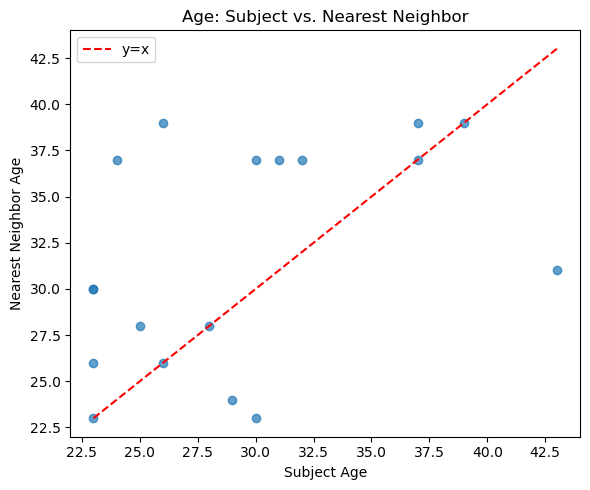

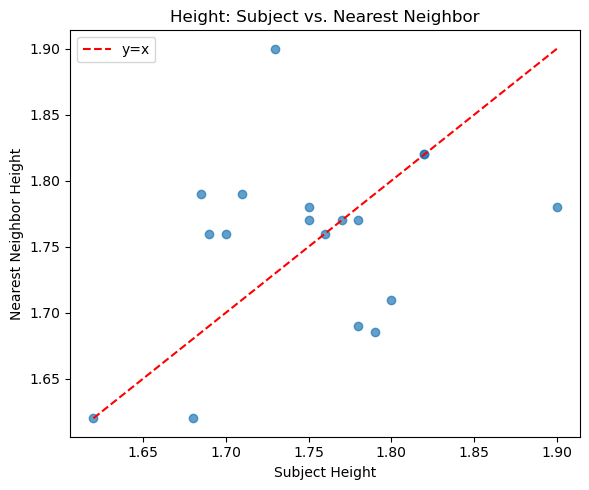

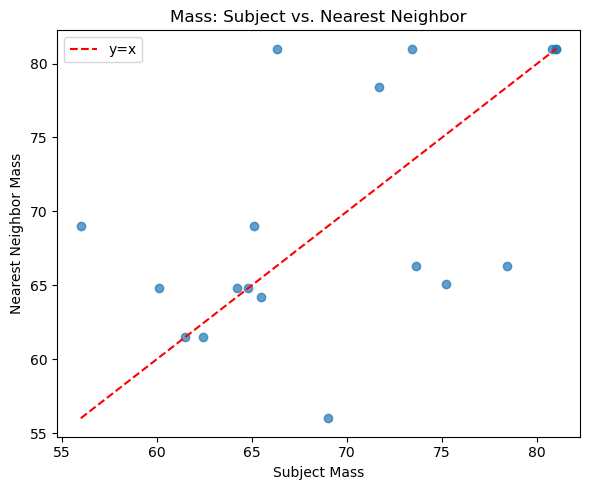

In [7]:
import matplotlib.pyplot as plt
import numpy as np

dataset = loader.dataset
subject_metadata = dataset.subject_metadata

# Use subject names from subject_latents to ensure consistency
subject_list = list(subject_latents.keys())
metadata_keys = ['age', 'height', 'mass']

k = 1
# Build train_profiles in the same order as subject_list
train_profiles = []
for subject in subject_list:
    latents = subject_latents[subject]
    latents_tensor = torch.stack(latents).to(device)
    # Use your encoder to get the profile (mean over all latents for this subject)
    profile_vectors = encoder(latents_tensor).detach().cpu().numpy()
    profile = profile_vectors.mean(axis=0)
    train_profiles.append(profile)
train_profiles = np.stack(train_profiles)

# Fit kNN on these profiles
knn = KNeighborsClassifier(n_neighbors=k+1)
knn.fit(train_profiles, np.arange(len(subject_list)))
neighbors = knn.kneighbors(train_profiles, n_neighbors=k+1, return_distance=False)

for key in metadata_keys:
    subj_vals = []
    neighbor_vals = []
    for i, subject in enumerate(subject_list):
        subj_meta = subject_metadata.get(subject, None)
        if subj_meta is None:
            print(f"Subject {subject} not found in metadata.")
            continue
        subj_val = subj_meta.get(key, None)
        if subj_val is None or subj_val == 0 or subj_val == 'unknown':
            print(f"Missing {key} for subject {subject}")
            continue

        # Find nearest neighbor (excluding self)
        neighbor_idx = neighbors[i][1]
        neighbor_subject = subject_list[neighbor_idx]
        neighbor_meta = subject_metadata.get(neighbor_subject, None)
        if neighbor_meta is None:
            print(f"Neighbor {neighbor_subject} not found in metadata.")
            continue
        neighbor_val = neighbor_meta.get(key, None)
        if neighbor_val is None or neighbor_val == 0 or neighbor_val == 'unknown':
            print(f"Missing {key} for neighbor {neighbor_subject}")
            continue

        subj_vals.append(subj_val)
        neighbor_vals.append(neighbor_val)

    if len(subj_vals) == 0:
        print(f"No valid pairs for {key}, skipping plot.")
        continue

    plt.figure(figsize=(6, 5))
    plt.scatter(subj_vals, neighbor_vals, alpha=0.7)
    plt.xlabel(f"Subject {key.capitalize()}")
    plt.ylabel(f"Nearest Neighbor {key.capitalize()}")
    plt.title(f"{key.capitalize()}: Subject vs. Nearest Neighbor")
    min_val = min(subj_vals + neighbor_vals)
    max_val = max(subj_vals + neighbor_vals)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x')
    plt.legend()
    plt.tight_layout()
    plt.show()

Subject: Falisse2017/subject_8
Nearest neighbor: Falisse2017/subject_7
Furthest neighbor: Wang2023/Subj12
Average displacement (subject vs. nearest neighbor): 0.2896
Average displacement (subject vs. furthest neighbor): 0.3287
Mean average displacement (all subjects vs. nearest neighbor): 0.1800
Mean average displacement (all subjects vs. furthest neighbor): 0.2782


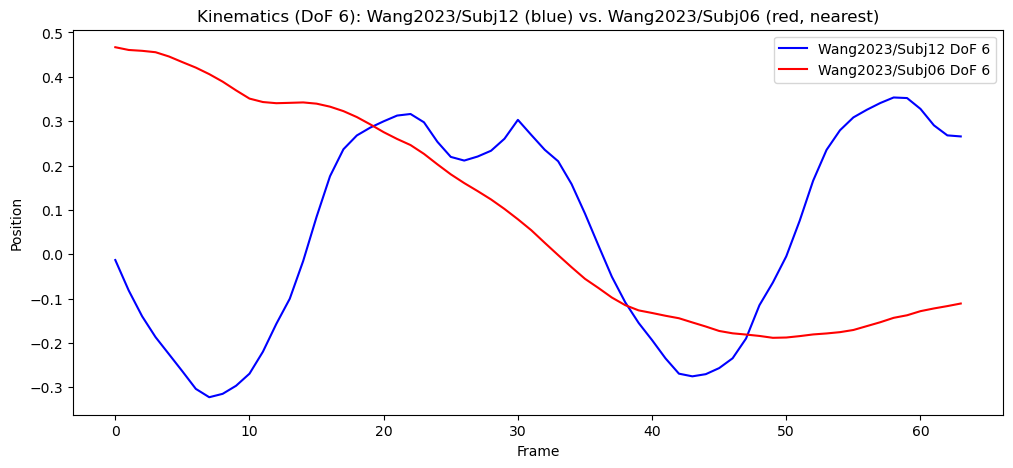

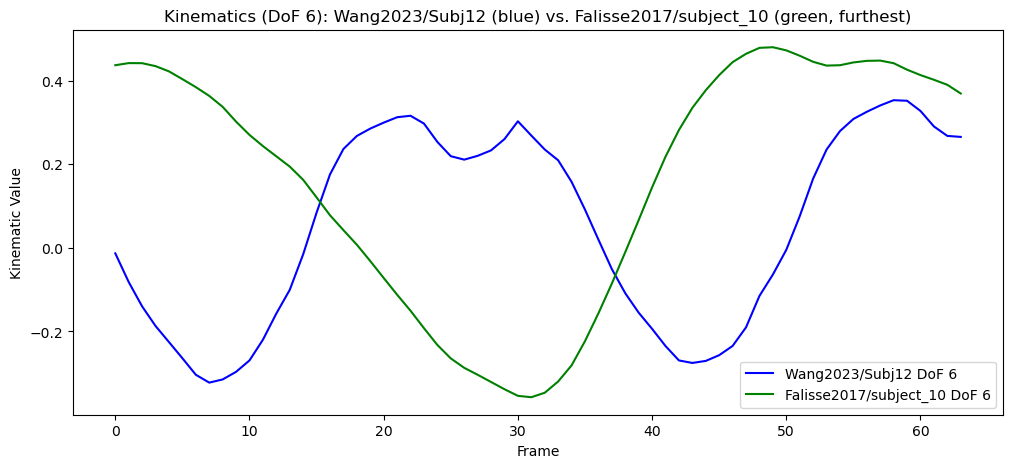

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
import nimblephysics as nimble
import os

# --- Store original kinematics for each subject during latent extraction ---
subject_latents = defaultdict(list)
subject_kinematics = defaultdict(list)
subject_joint_forces = defaultdict(list)
subject_motion_names = defaultdict(list)

def extract_subject_from_name(name):
    b3d_path = name.split("::")[0]
    parts = b3d_path.split(os.sep)
    if len(parts) >= 2:
        folder = parts[-2]
        if '_split' in folder:
            return folder.split('_split')[0]
        else:
            return folder
    else:
        return "unknown_subject"

with torch.no_grad():
    for batch in loader:
        motions, lengths, names, subject_names = batch
        motions = motions.to(device, dtype=torch.float32)
        latents = model.vqvae.encoder(model.vqvae.preprocess(motions))
        for motion, latent, name, subject_name in zip(motions, latents, names, subject_names):
            subject_latents[subject_name].append(latent.cpu())
            subject_kinematics[subject_name].append(motion.cpu())
            subject_motion_names[subject_name].append(name)
            # Joint forces will be loaded from b3d below

# --- Find nearest and furthest neighbors in profile space ---
subject_list = sorted(list(subject_latents.keys()))
subject = subject_list[8]  # You can change this to any subject in your data

# Compute profile for the subject
latents = subject_latents[subject]
latents_tensor = torch.stack(latents).to(device)
profile = encoder(latents_tensor).detach().cpu().numpy().mean(axis=0).reshape(1, -1)

# Compute all subject profiles
all_profiles = []
for s in subject_list:
    lats = subject_latents[s]
    lats_tensor = torch.stack(lats).to(device)
    prof = encoder(lats_tensor).detach().cpu().numpy().mean(axis=0)
    all_profiles.append(prof)
all_profiles = np.stack(all_profiles)

# Find nearest and furthest neighbor (excluding self)
dists = euclidean_distances(profile, all_profiles)[0]
dists_self = np.argsort(dists)
nearest_idx = dists_self[1]  # [0] is self
furthest_idx = dists_self[-1]

nearest_subject = subject_list[nearest_idx]
furthest_subject = subject_list[furthest_idx]

print(f"Subject: {subject}")
print(f"Nearest neighbor: {nearest_subject}")
print(f"Furthest neighbor: {furthest_subject}")

# --- Plot kinematics for the first motion of subject and nearest/furthest neighbor ---
motion_subject = subject_kinematics[subject][0].numpy()
motion_nearest = subject_kinematics[nearest_subject][0].numpy()
motion_furthest = subject_kinematics[furthest_subject][0].numpy()

dof = 6  # Change this index to plot a different degree of freedom

# Compute average displacement between subject and nearest neighbor
# motion_subject and motion_nearest: shape (num_frames, num_joints)
if motion_subject.shape == motion_nearest.shape:
    # Per-frame, per-joint displacement
    displacement = np.abs(motion_subject - motion_nearest)  # shape (num_frames, num_joints)
    avg_displacement = displacement.mean()
    print(f"Average displacement (subject vs. nearest neighbor): {avg_displacement:.4f}")
else:
    print("Motion shapes do not match for displacement calculation.")

# For furthest neighbor
if motion_subject.shape == motion_furthest.shape:
    displacement_furthest = np.abs(motion_subject - motion_furthest)
    avg_displacement_furthest = displacement_furthest.mean()
    print(f"Average displacement (subject vs. furthest neighbor): {avg_displacement_furthest:.4f}")
else:
    print("Motion shapes do not match for displacement calculation.")


# --- Compute average displacement for all subjects and their nearest/furthest neighbors ---

all_avg_disp_nearest = []
all_avg_disp_furthest = []

for i, subject in enumerate(subject_list):
    # Get nearest and furthest neighbor indices (excluding self)
    nearest_idx = neighbors[i][1]
    furthest_idx = np.argmax(euclidean_distances(
        train_profiles[i].reshape(1, -1), train_profiles
    )[0])

    nearest_subject = subject_list[nearest_idx]
    furthest_subject = subject_list[furthest_idx]

    # Get first motion for each subject (or use another selection strategy)
    motion_subject = subject_kinematics[subject][0].numpy()
    motion_nearest = subject_kinematics[nearest_subject][0].numpy()
    motion_furthest = subject_kinematics[furthest_subject][0].numpy()

    # Only compare if shapes match
    if motion_subject.shape == motion_nearest.shape:
        displacement = np.abs(motion_subject - motion_nearest)
        avg_disp = displacement.mean()
        all_avg_disp_nearest.append(avg_disp)
    if motion_subject.shape == motion_furthest.shape:
        displacement_furthest = np.abs(motion_subject - motion_furthest)
        avg_disp_furthest = displacement_furthest.mean()
        all_avg_disp_furthest.append(avg_disp_furthest)

# Report the averages
if all_avg_disp_nearest:
    print(f"Mean average displacement (all subjects vs. nearest neighbor): {np.mean(all_avg_disp_nearest):.4f}")
else:
    print("No valid nearest neighbor pairs for displacement calculation.")

if all_avg_disp_furthest:
    print(f"Mean average displacement (all subjects vs. furthest neighbor): {np.mean(all_avg_disp_furthest):.4f}")
else:
    print("No valid furthest neighbor pairs for displacement calculation.")

plt.figure(figsize=(12, 5))
plt.plot(motion_subject[:, dof], label=f'{subject} DoF {dof}', color='blue')
plt.plot(motion_nearest[:, dof], label=f'{nearest_subject} DoF {dof}', color='red')
plt.title(f"Kinematics (DoF {dof}): {subject} (blue) vs. {nearest_subject} (red, nearest)")
plt.xlabel("Frame")
plt.ylabel("Position")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(motion_subject[:, dof], label=f'{subject} DoF {dof}', color='blue')
plt.plot(motion_furthest[:, dof], label=f'{furthest_subject} DoF {dof}', color='green')
plt.title(f"Kinematics (DoF {dof}): {subject} (blue) vs. {furthest_subject} (green, furthest)")
plt.xlabel("Frame")
plt.ylabel("Kinematic Value")
plt.legend()
plt.show()


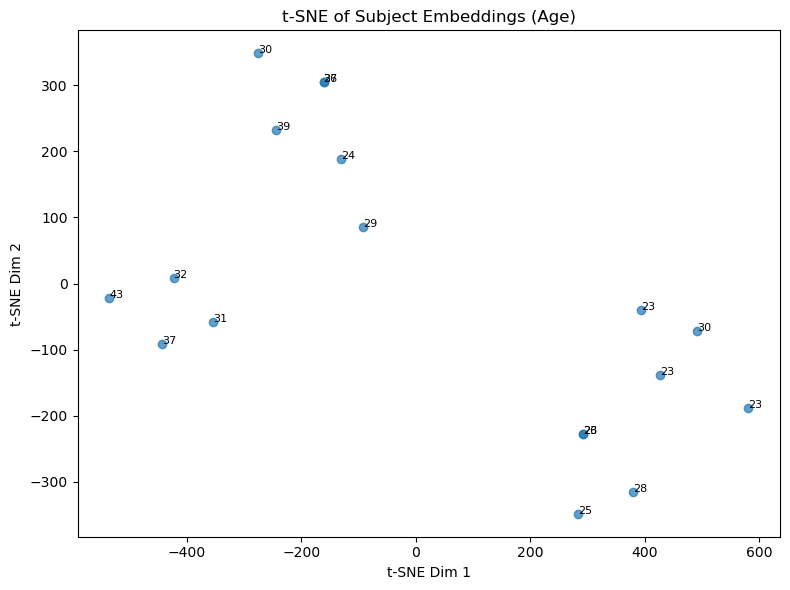

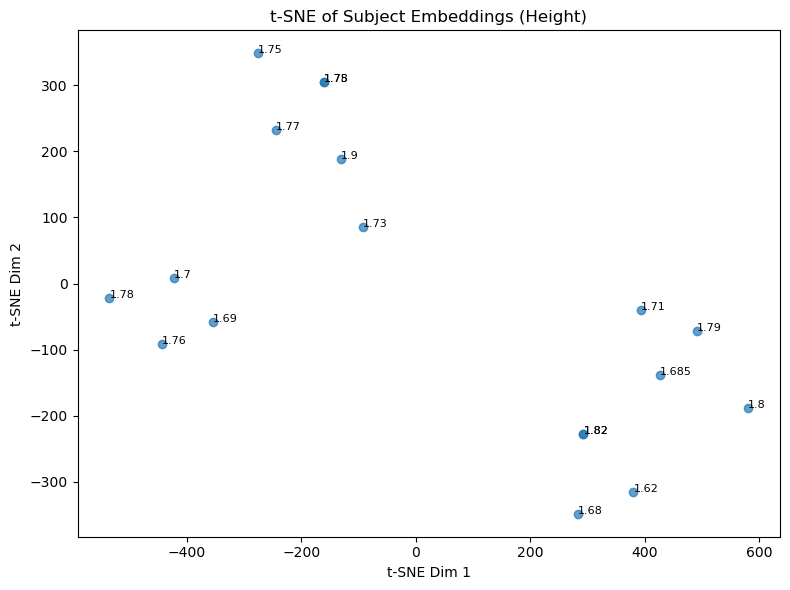

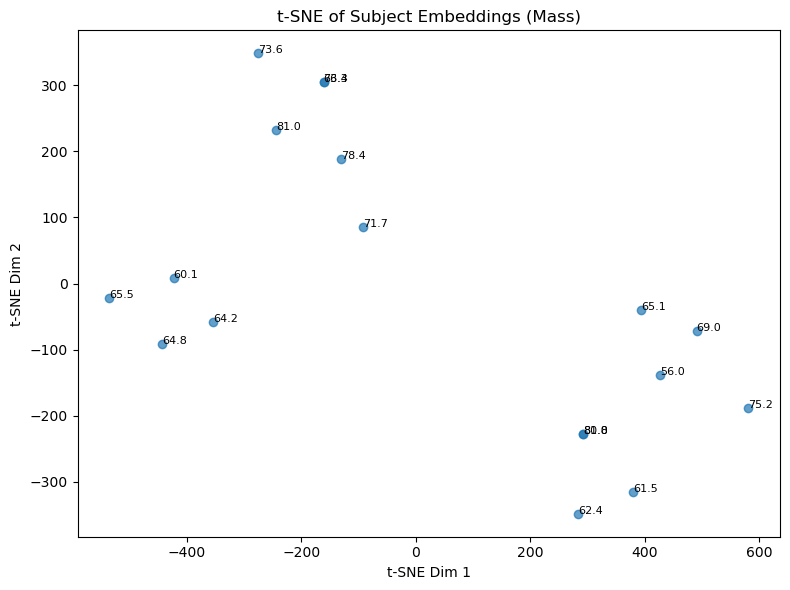

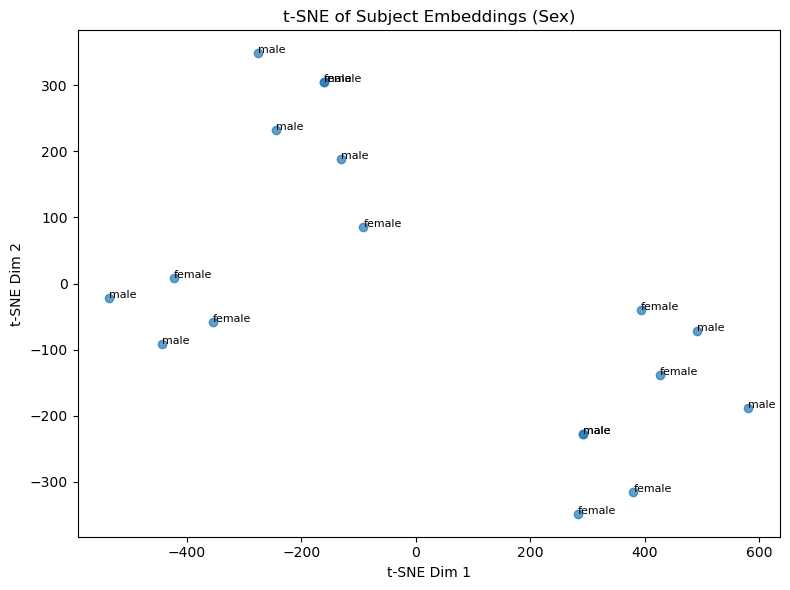

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Compute subject embeddings (profiles) as before
subject_list = sorted(subject_latents.keys())
embeddings = []
ages = []
heights = []
masses = []
sexes = []
for subject in subject_list:
    latents = subject_latents[subject]
    latents_tensor = torch.stack(latents).to(device)
    profile_vectors = encoder(latents_tensor).detach().cpu().numpy()
    profile = profile_vectors.mean(axis=0)
    embeddings.append(profile)
    # Get metadata, use 'unknown' if not available
    meta = subject_metadata.get(subject, {})
    ages.append(meta.get('age', 'unknown'))
    heights.append(meta.get('height', 'unknown'))
    masses.append(meta.get('mass', 'unknown'))
    sexes.append(meta.get('sex', 'unknown'))
embeddings = np.stack(embeddings)

# Run TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot for age
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
for i, age in enumerate(ages):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(age), fontsize=8)
plt.title("t-SNE of Subject Embeddings (Age)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()

# Plot for height
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
for i, height in enumerate(heights):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(height), fontsize=8)
plt.title("t-SNE of Subject Embeddings (Height)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()

# Plot for mass
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
for i, mass in enumerate(masses):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(mass), fontsize=8)
plt.title("t-SNE of Subject Embeddings (Mass)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()

# Plot for sex
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
for i, sex in enumerate(sexes):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(sex), fontsize=8)
plt.title("t-SNE of Subject Embeddings (Sex)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()

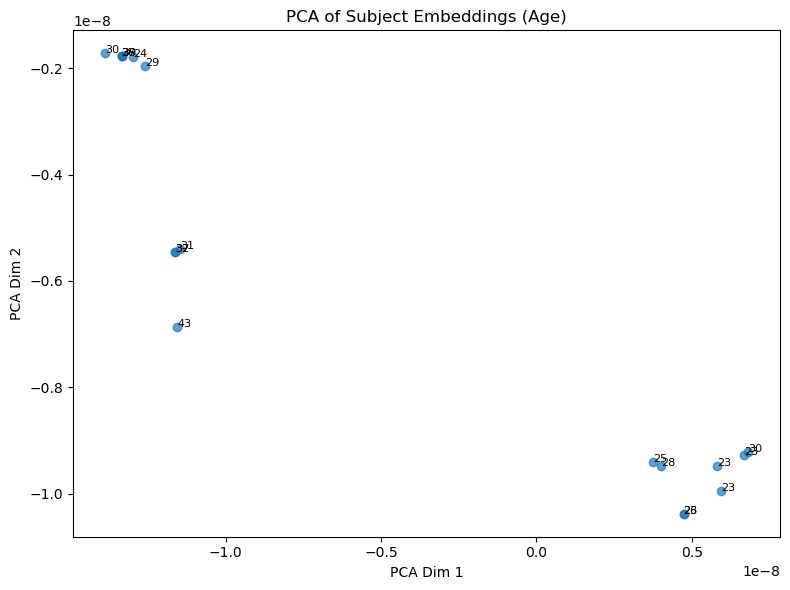

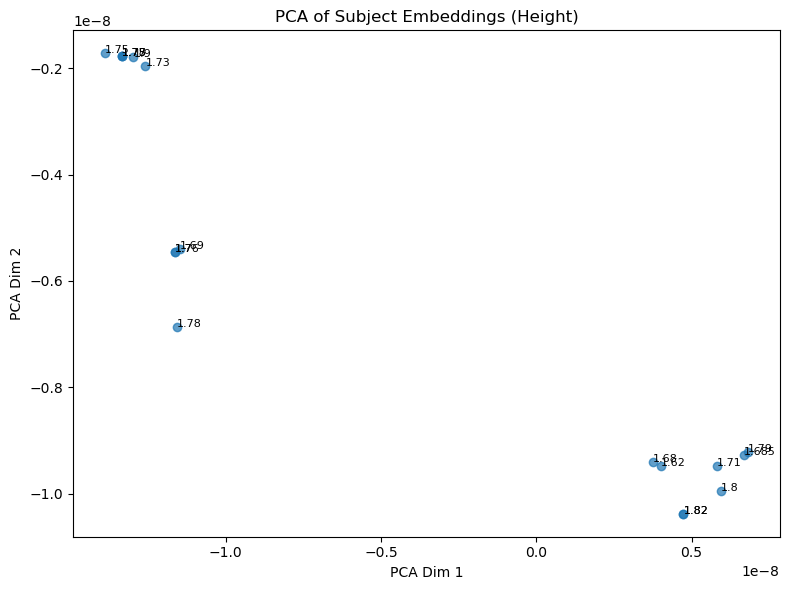

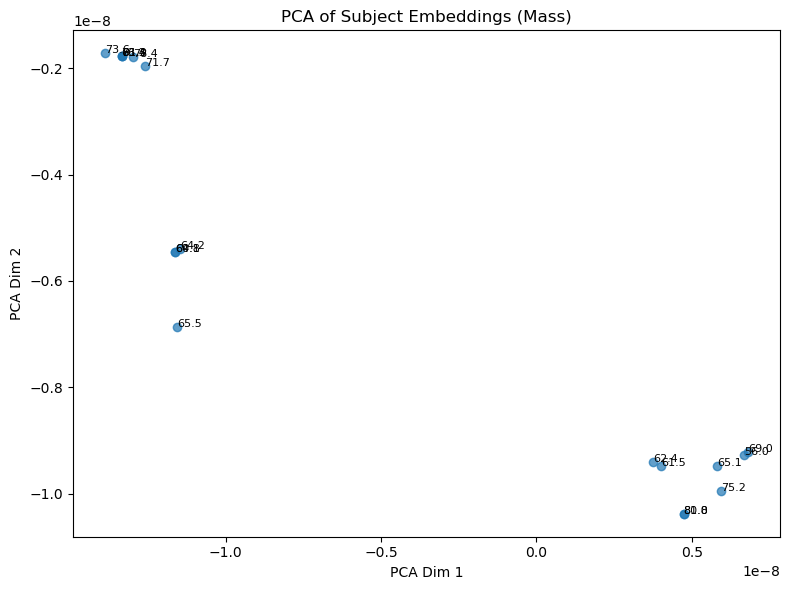

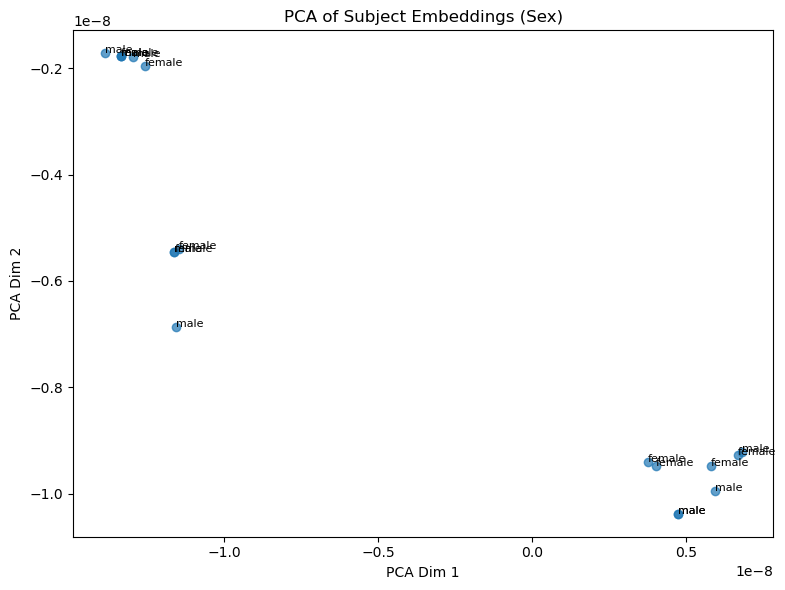

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA on subject embeddings
pca = PCA(n_components=2, random_state=42)
embeddings_2d_pca = pca.fit_transform(embeddings)

# Plot for age
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], alpha=0.7)
for i, age in enumerate(ages):
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], str(age), fontsize=8)
plt.title("PCA of Subject Embeddings (Age)")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.tight_layout()
plt.show()

# Plot for height
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], alpha=0.7)
for i, height in enumerate(heights):
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], str(height), fontsize=8)
plt.title("PCA of Subject Embeddings (Height)")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.tight_layout()
plt.show()

# Plot for mass
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], alpha=0.7)
for i, mass in enumerate(masses):
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], str(mass), fontsize=8)
plt.title("PCA of Subject Embeddings (Mass)")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.tight_layout()
plt.show()

# Plot for sex
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], alpha=0.7)
for i, sex in enumerate(sexes):
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], str(sex), fontsize=8)
plt.title("PCA of Subject Embeddings (Sex)")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.tight_layout()
plt.show()

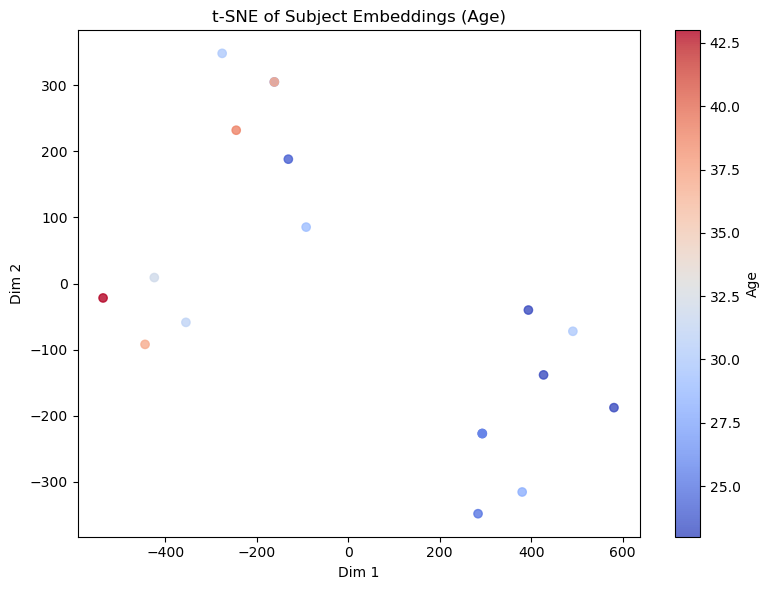

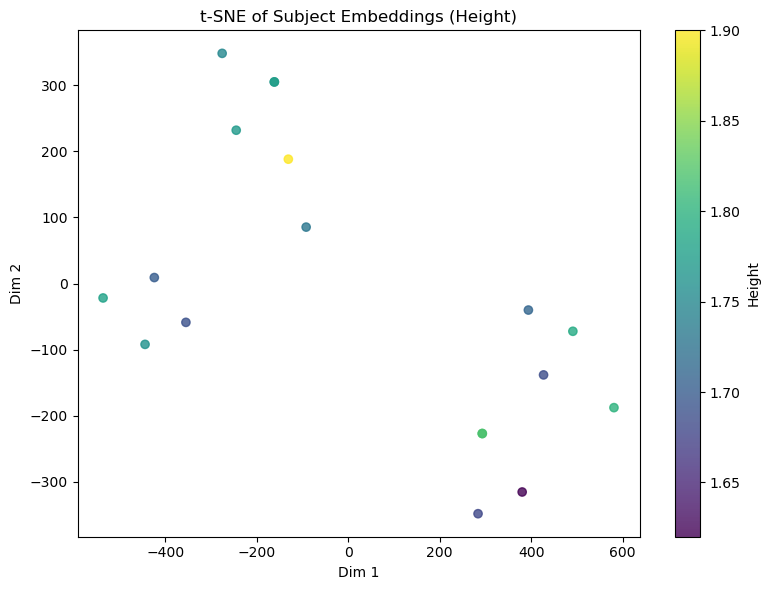

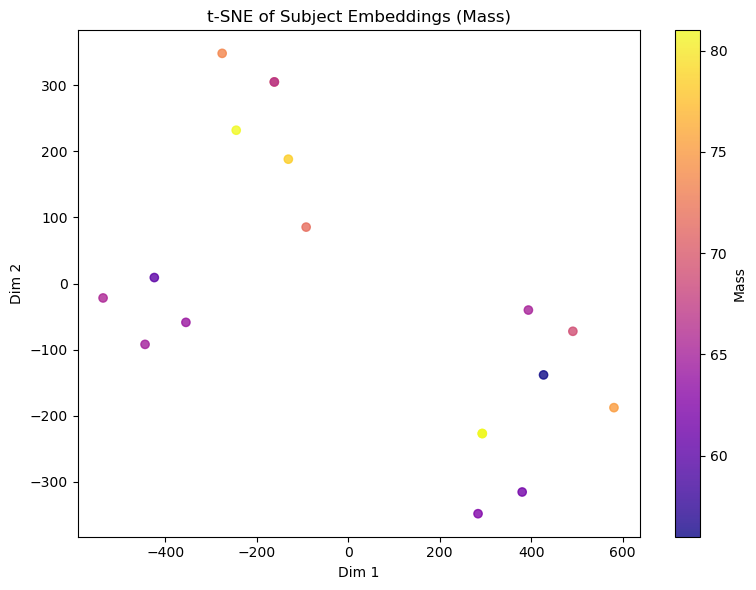

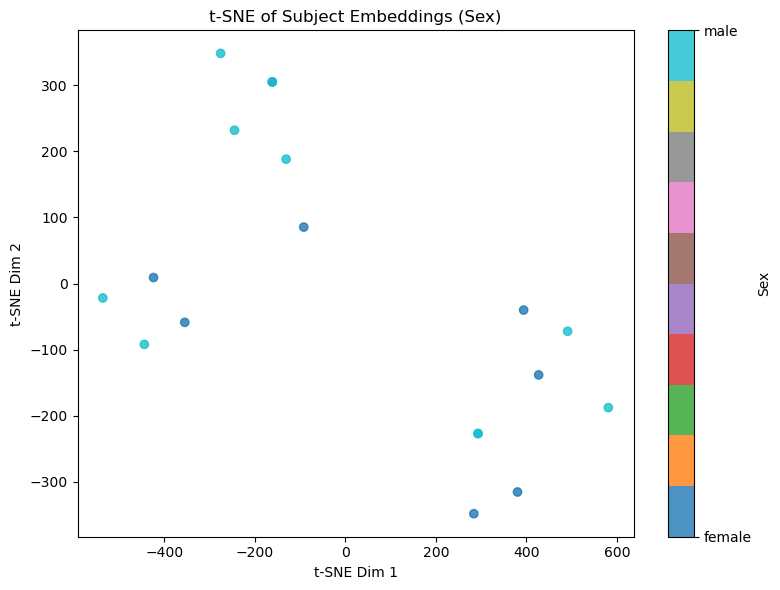

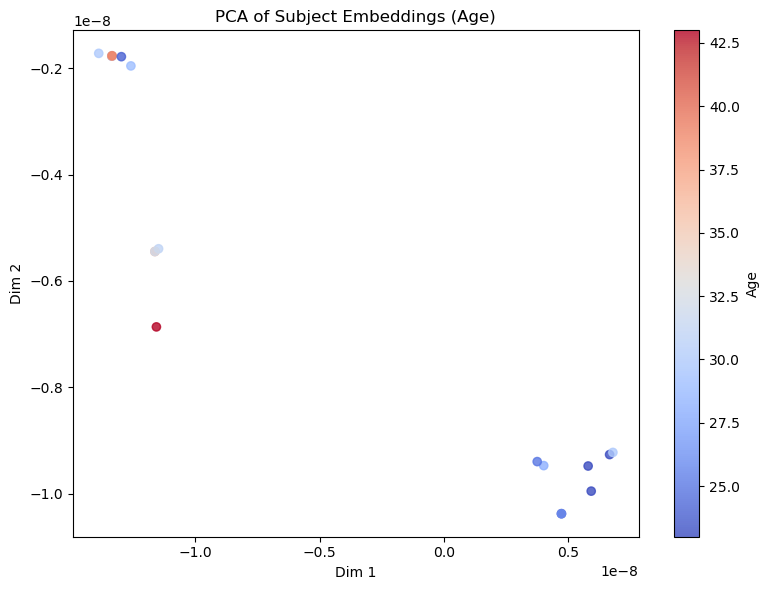

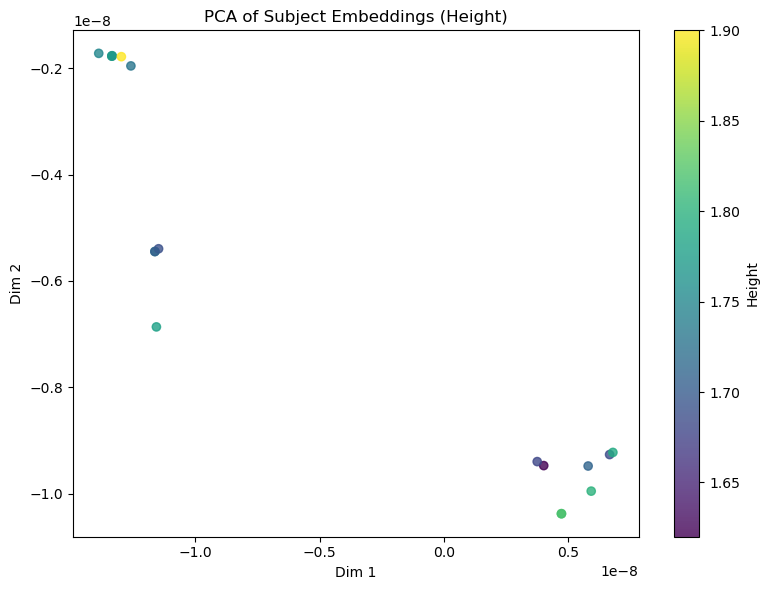

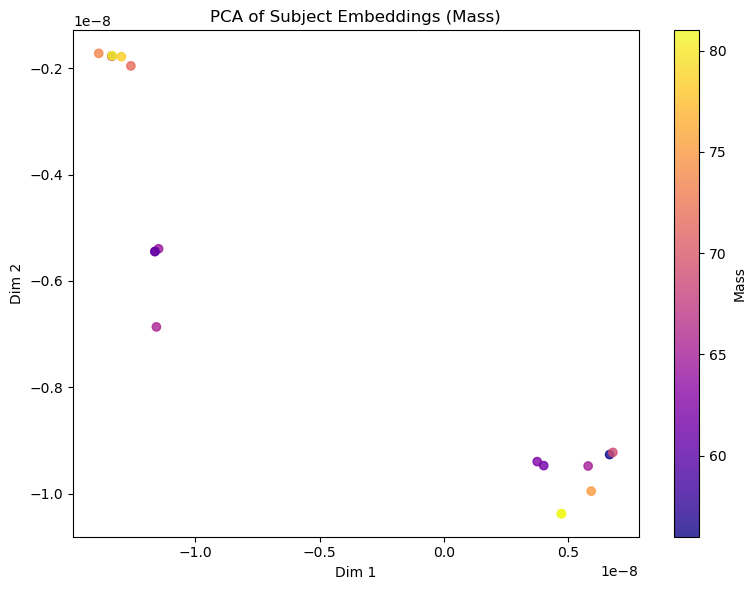

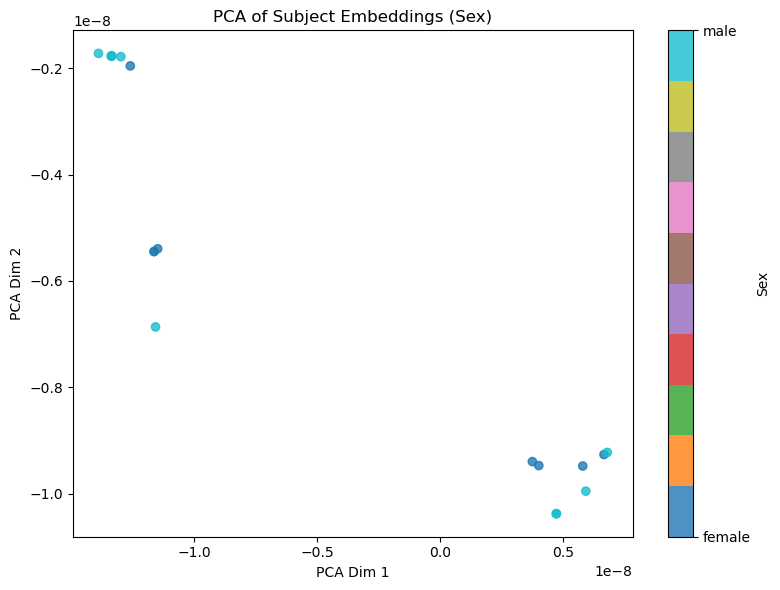

In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# --- t-SNE plots with heatmap coloring ---

def plot_heatmap_scatter(embeddings_2d, values, title, cmap='viridis', colorbar_label=None):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=values, cmap=cmap, alpha=0.8)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    cbar = plt.colorbar(scatter)
    if colorbar_label:
        cbar.set_label(colorbar_label)
    plt.tight_layout()
    plt.show()

# Convert values to numeric for color mapping, handle 'unknown'
def to_numeric(arr):
    arr = np.array(arr)
    mask = arr == 'unknown'
    arr_num = np.where(mask, np.nan, arr).astype(float)
    return arr_num

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)

plot_heatmap_scatter(embeddings_2d, to_numeric(ages), "t-SNE of Subject Embeddings (Age)", cmap='coolwarm', colorbar_label='Age')
plot_heatmap_scatter(embeddings_2d, to_numeric(heights), "t-SNE of Subject Embeddings (Height)", cmap='viridis', colorbar_label='Height')
plot_heatmap_scatter(embeddings_2d, to_numeric(masses), "t-SNE of Subject Embeddings (Mass)", cmap='plasma', colorbar_label='Mass')

# For sex, use categorical coloring
sexes_arr = np.array(sexes)
unique_sexes = np.unique(sexes_arr)
sex_to_num = {sex: i for i, sex in enumerate(unique_sexes)}
sex_numeric = np.array([sex_to_num[s] for s in sexes_arr])
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=sex_numeric, cmap='tab10', alpha=0.8)
plt.title("t-SNE of Subject Embeddings (Sex)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
cbar = plt.colorbar(scatter, ticks=range(len(unique_sexes)))
cbar.ax.set_yticklabels(unique_sexes)
cbar.set_label('Sex')
plt.tight_layout()
plt.show()

# --- PCA plots with heatmap coloring ---

pca = PCA(n_components=2, random_state=42)
embeddings_2d_pca = pca.fit_transform(embeddings)

plot_heatmap_scatter(embeddings_2d_pca, to_numeric(ages), "PCA of Subject Embeddings (Age)", cmap='coolwarm', colorbar_label='Age')
plot_heatmap_scatter(embeddings_2d_pca, to_numeric(heights), "PCA of Subject Embeddings (Height)", cmap='viridis', colorbar_label='Height')
plot_heatmap_scatter(embeddings_2d_pca, to_numeric(masses), "PCA of Subject Embeddings (Mass)", cmap='plasma', colorbar_label='Mass')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], c=sex_numeric, cmap='tab10', alpha=0.8)
plt.title("PCA of Subject Embeddings (Sex)")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
cbar = plt.colorbar(scatter, ticks=range(len(unique_sexes)))
cbar.ax.set_yticklabels(unique_sexes)
cbar.set_label('Sex')
plt.tight_layout()
plt.show()